In [1]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import os
import pandas as pd
import matplotlib.pyplot as plt
from torchvision.io import read_image

class Birds270Dataset(Dataset):
    def make_labels(self, csv_table):
        bird_str_labels = csv_table["labels"].unique()
        self.labels_str_to_int = {label:i  for i, label in enumerate(bird_str_labels)}
        self.labels_int_to_str = {i:label  for i, label in enumerate(bird_str_labels)}
    def find_set_type(self, set_type):
        if type(set_type) is str:
            return [set_type]
        else:
            return set_type
        
    def __init__(self, dataset_dir, set_type=None, transform=None, selected_birds=None):
        set_type_list = self.find_set_type(set_type)
        csv_table = pd.read_csv(os.path.join(dataset_dir, "birds.csv"))
        if selected_birds != None:
            csv_table = csv_table[csv_table["labels"].isin(selected_birds)]
        if set_type == None:
            self.img_data = csv_table
        else:
            self.img_data = csv_table[csv_table["data set"].isin(set_type_list)]
        self.make_labels(self.img_data)
        self.dataset_dir = dataset_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_data)

    def __getitem__(self, idx):
        filepaths_col = self.img_data.columns.get_loc("filepaths")
        labels_col = self.img_data.columns.get_loc("labels")
        img_path = os.path.join(self.dataset_dir, self.img_data.iat[idx, filepaths_col])
        image = read_image(img_path).float()
        label = self.img_data.iat[idx, labels_col]
        if self.transform:
            image = self.transform(image)
        int_label = self.labels_str_to_int[label]
        return image, int_label
    



In [2]:
def make2d(int_or_tuple):
    if(type(int_or_tuple) is int):
        return (int_or_tuple,int_or_tuple)
    else:
        return int_or_tuple
# Returns the dimensions of the image after performing nn.Conv2d
def dim_conv2d(size_in, kernel_size, stride=1, padding=0, dilation=1):
    kernel_size = make2d(kernel_size)
    stride = make2d(stride)
    padding = make2d(padding)
    dilation = make2d(dilation)
    height_out = int((size_in[0] + 2*padding[0] - dilation[0]*(kernel_size[0]-1) - 1)/stride[0] + 1)
    width_out = int((size_in[1] + 2*padding[1] - dilation[1]*(kernel_size[1]-1) - 1)/stride[1] + 1)
    return (height_out, width_out)

# Returns the dimensions of the image after performing nn.MaxPool2d
def dim_maxpool2d(size_in, kernel_size, stride=None, padding=0, dilation=1):
    if stride == None:
        stride = kernel_size
    # The formula is the same as for dim_conv2d
    return dim_conv2d(size_in, kernel_size, stride=stride, padding=padding, dilation=dilation)


In [25]:
dataset_dir = "../data/birds270"
selected_birds = ["ALBATROSS", "BALD EAGLE", "BARN OWL", "EURASIAN MAGPIE", "FLAMINGO",
                  "MALLARD DUCK", "OSTRICH", "PEACOCK", "PELICAN", "TRUMPTER SWAN"]
train_transform= transforms.Compose([
#    transforms.RandomHorizontalFlip(),
#    transforms.RandomResizedCrop(224, scale=(0.5, 1.0)),
#    transforms.RandomPerspective(),
#    transforms.RandomRotation(45, interpolation=transforms.functional.InterpolationMode.BILINEAR),
#    transforms.ColorJitter(brightness=0.3, saturation = 0.3),
    transforms.Normalize((127.5, 127.5, 127.5), (127.5, 127.5, 127.5))
])
test_transform = transforms.Normalize((127.5, 127.5, 127.5), (127.5, 127.5, 127.5)) # normalizes colors to range [-1,1]
train_dataset = Birds270Dataset(dataset_dir, set_type="train", selected_birds=selected_birds, transform=train_transform)
test_dataset = Birds270Dataset(dataset_dir, set_type=["test","valid"], selected_birds=selected_birds, transform=test_transform)
full_dataset = Birds270Dataset(dataset_dir, selected_birds=selected_birds, transform=train_transform)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import datetime

kernel_size = 5

def conv_out_size(height, width):
    dim = (height, width)
    dim = dim_conv2d(dim, kernel_size)
    dim = dim_maxpool2d(dim, 2, 2)
    dim = dim_conv2d(dim, kernel_size)
    dim = dim_maxpool2d(dim, 2, 2)
    return dim

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size)
        conv_height, conv_width = conv_out_size(224, 224)
        self.fc1 = nn.Linear(16 * conv_width * conv_height, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.01):
        self.previous_loss = None
        self.epochs_no_improvement = 0
        self.patience = patience
        self.min_delta = min_delta
    
    def report_loss(self, loss):
        if self.is_improvement(loss):
            self.epochs_no_improvement = 0
            self.previous_loss = loss
        else:
            self.epochs_no_improvement += 1

    def should_stop(self):
        return self.epochs_no_improvement >= self.patience
    
    def is_improvement(self, loss):
        return self.previous_loss == None or loss < self.previous_loss - self.min_delta
    

def train(net, train_dataloader, criterion, optimizer, device="cpu"):
    net.train()
    running_loss = 0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * inputs.size(0)
        loss.backward()
        optimizer.step()
    epoch_loss = running_loss / len(train_dataloader.dataset)
    return {"loss":epoch_loss}

def evaluate(net, test_dataloader, criterion, device="cpu"):
    net.eval()
    correct = 0
    total = 0
    correct_labels = {label_str: 0 for label_str in test_dataset.labels_str_to_int.keys()}
    total_labels = {label_str: 0 for label_str in test_dataset.labels_str_to_int.keys()}
    running_loss = 0
    with torch.no_grad():
        for data in test_dataloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            for label, prediction in zip(labels, predicted):
                if label == prediction:
                    correct_labels[test_dataset.labels_int_to_str[label.item()]] += 1
                total_labels[test_dataset.labels_int_to_str[label.item()]] += 1
    accuracy = correct/total
    label_accuracy = calculate_label_accuracy(correct_labels, total_labels)
    epoch_loss = running_loss / len(test_dataloader.dataset)
    return {"correct":correct, "total":total, "accuracy":accuracy, "loss":epoch_loss,
            "correct_labels":correct_labels, "total_labels":total_labels, "label_accuracy":label_accuracy}

def calculate_label_accuracy(correct_labels, total_labels):
    label_accuracy = {}
    for label_str, correct_label in correct_labels.items():
        total_label = total_labels[label_str]
        if total_label == 0:
            label_accuracy[label_str] = np.nan
        else:
            label_accuracy[label_str] = correct_label / total_label

def print_epoch_results(epoch_results):
    print_epoch_results_unpacked(**epoch_results)

def print_epoch_results_unpacked(epoch,train_loss, val_loss, val_accuracy, elapsed_time):
    print(f"Epoch {epoch}:")
    print(f"\ttrain loss: {train_loss}")
    print(f"\tvalidation loss: {val_loss}, validation accuracy: {100 * val_accuracy}%")
    print(f"\tElapsed time: {elapsed_time}")

def print_final_results(final_results):
    final_loss = final_results["loss"]
    final_accuracy = final_results["correct"]/final_results["total"]
    print(f"Final loss: {final_loss}, final accuracy: {100*final_accuracy} %")
    print_label_accuracy(final_results["correct_labels"], final_results["total_labels"])

def print_label_accuracy(correct_labels, total_labels):
    for label_str, correct_label in correct_labels.items():
        total_label = total_labels[label_str]
        if total_label != 0:
            print(f"\t{label_str}: {100 * correct_label / total_label}")

def train_and_evaluate(net, train_dataloader, test_dataloader, epochs=30, optimizer=None, print_results=False):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer  = optim.Adam(net.parameters()) if optimizer == None else optimizer
    all_epoch_results = []
    for epoch in range(epochs):
        start_time = datetime.datetime.now()
        train_results = train(net, train_dataloader, criterion, optimizer, device=device)
        results = evaluate(net, test_dataloader, criterion, device=device)
        time_elapsed = datetime.datetime.now() - start_time
        train_loss = train_results["loss"]
        val_loss = results["loss"]
        accuracy = results["accuracy"]
        epoch_results = {"epoch":epoch, "train_loss":train_loss, "val_loss":val_loss, "val_accuracy":accuracy,
                          "elapsed_time":time_elapsed}
        all_epoch_results += epoch_results
        if print_results:
            print_epoch_results(epoch_results)

    final_results = evaluate(net, test_dataloader, criterion, device=device)
    if print_results:
        print_final_results(final_results)
    return final_results
    
        
net = Net()
train_and_evaluate(net, train_dataloader, test_dataloader, epochs=30, print_results=True)

torch.save(net, '../model/simple_DB_model.pth')
torch.save(net.state_dict(), '../model/simple_DB_model_weights.pth')


Epoch 0:
	train loss: 2.013315346525414
	validation loss: 1.5271309852600097, validation accuracy: 49.0%
	Elapsed time: 0:00:10.707188
Epoch 1:
	train loss: 1.3439458864953626
	validation loss: 1.1239781332015992, validation accuracy: 65.0%
	Elapsed time: 0:00:10.941066
Epoch 2:
	train loss: 0.9148459638165796
	validation loss: 0.8908395218849182, validation accuracy: 68.0%
	Elapsed time: 0:00:10.987875
Epoch 3:
	train loss: 0.596810948515149
	validation loss: 0.8693102025985717, validation accuracy: 72.0%
	Elapsed time: 0:00:10.997737
Epoch 4:
	train loss: 0.30462580598857864
	validation loss: 0.7340549743175506, validation accuracy: 77.0%
	Elapsed time: 0:00:11.235596
Epoch 5:
	train loss: 0.13944966418446428
	validation loss: 0.8728764152526856, validation accuracy: 76.0%
	Elapsed time: 0:00:11.339358
Epoch 6:
	train loss: 0.054698967211639755
	validation loss: 0.8235789376497269, validation accuracy: 81.0%
	Elapsed time: 0:00:10.744817
Epoch 7:
	train loss: 0.038608422069446854
	va

In [24]:
import statistics
import torch.utils.data as td
def train_net_random_dataset_split(net, dataset, epochs, optimizer, batch_size):
    train_set_size = int(len(dataset)*0.8)
    test_set_size = len(dataset)-train_set_size
    train_dataset, test_dataset = td.random_split(full_dataset, [train_set_size, test_set_size])
    train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size, shuffle=True)
    results = train_and_evaluate(net, train_dataloader, test_dataloader,
                                 epochs=epochs, optimizer=optimizer, print_results=False)
    return results

def cross_validate_net(net_generator, dataset, repeat=5, epochs=10, optimizer=None, batch_size=32):
    all_results = []
    for i in range(repeat):
        print(f"Network {i+1}")
        net = net_generator()
        results = train_net_random_dataset_split(net, dataset, epochs, optimizer, batch_size=32)
        all_results.append(results)
    losses = [r["loss"] for r in all_results]
    accuracies = [r["accuracy"] for r in all_results]
    print("Losses: ", losses)
    print("Loss:  mean: {:.4f}, std: {:.4f}".format(statistics.mean(losses), statistics.stdev(losses)))
    print("Accuracies: ", accuracies)
    print("Accuracy:  mean: {:.4f}, std: {:.4f}".format(statistics.mean(accuracies), statistics.stdev(accuracies)))
    
cross_validate_net(Net, full_dataset, repeat=5)

Network 1
Network 2
Network 3
Network 4
Network 5
Losses:  [1.1082943481941745, 1.2063594542137563, 0.9985311210971989, 1.0255404049403047, 1.1170063345399621]
Loss:  mean: 1.0911, std: 0.0823
Accuracies:  [0.6575342465753424, 0.6506849315068494, 0.6815068493150684, 0.7054794520547946, 0.5993150684931506]
Accuracy:  mean: 0.6589, std: 0.0397


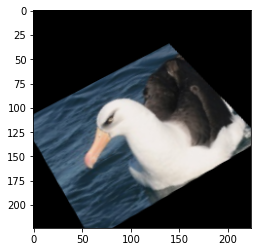

Label (number): 0, (name): ALBATROSS
TRUMPTER SWAN: 13.89%
MALLARD DUCK: 10.79%
BARN OWL: 10.47%
EURASIAN MAGPIE: 10.46%
BALD EAGLE: 10.05%
FLAMINGO: 9.06%
PELICAN: 9.00%
OSTRICH: 8.82%
ALBATROSS: 8.79%
PEACOCK: 8.65%


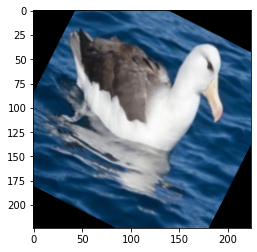

Label (number): 0, (name): ALBATROSS
TRUMPTER SWAN: 14.23%
BARN OWL: 10.65%
EURASIAN MAGPIE: 10.27%
MALLARD DUCK: 9.99%
PELICAN: 9.76%
BALD EAGLE: 9.71%
ALBATROSS: 9.69%
FLAMINGO: 9.32%
OSTRICH: 8.47%
PEACOCK: 7.92%


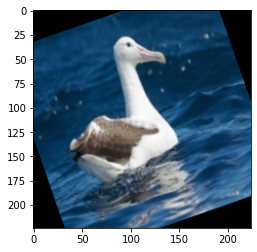

Label (number): 0, (name): ALBATROSS
TRUMPTER SWAN: 11.89%
MALLARD DUCK: 10.68%
BARN OWL: 10.64%
EURASIAN MAGPIE: 10.03%
BALD EAGLE: 9.97%
PELICAN: 9.92%
ALBATROSS: 9.73%
FLAMINGO: 9.35%
PEACOCK: 9.00%
OSTRICH: 8.80%


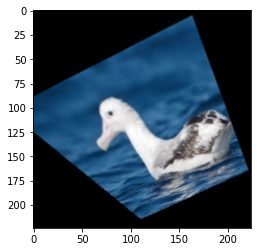

Label (number): 0, (name): ALBATROSS
TRUMPTER SWAN: 12.89%
EURASIAN MAGPIE: 10.52%
MALLARD DUCK: 10.47%
BARN OWL: 10.47%
BALD EAGLE: 10.38%
PELICAN: 9.43%
ALBATROSS: 9.37%
FLAMINGO: 9.12%
OSTRICH: 8.70%
PEACOCK: 8.66%


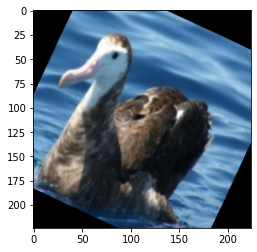

Label (number): 0, (name): ALBATROSS
MALLARD DUCK: 10.57%
BARN OWL: 10.53%
PELICAN: 10.43%
BALD EAGLE: 10.37%
TRUMPTER SWAN: 10.19%
EURASIAN MAGPIE: 10.13%
ALBATROSS: 10.02%
FLAMINGO: 9.94%
PEACOCK: 9.24%
OSTRICH: 8.58%


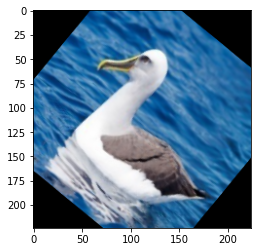

Label (number): 0, (name): ALBATROSS
TRUMPTER SWAN: 15.72%
MALLARD DUCK: 10.03%
BARN OWL: 10.03%
PELICAN: 9.78%
EURASIAN MAGPIE: 9.72%
FLAMINGO: 9.72%
OSTRICH: 9.15%
BALD EAGLE: 9.08%
ALBATROSS: 9.07%
PEACOCK: 7.70%


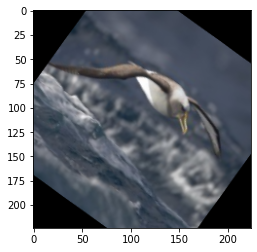

Label (number): 0, (name): ALBATROSS
MALLARD DUCK: 10.80%
BARN OWL: 10.58%
EURASIAN MAGPIE: 10.22%
TRUMPTER SWAN: 10.19%
PELICAN: 10.19%
FLAMINGO: 10.09%
ALBATROSS: 10.07%
BALD EAGLE: 9.63%
PEACOCK: 9.45%
OSTRICH: 8.77%


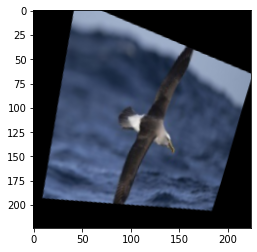

Label (number): 0, (name): ALBATROSS
MALLARD DUCK: 10.80%
TRUMPTER SWAN: 10.62%
BARN OWL: 10.50%
EURASIAN MAGPIE: 10.30%
PELICAN: 10.18%
BALD EAGLE: 9.92%
ALBATROSS: 9.80%
FLAMINGO: 9.78%
PEACOCK: 9.25%
OSTRICH: 8.85%


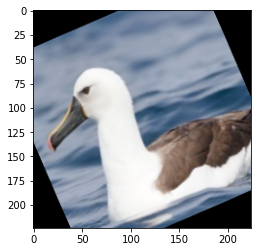

Label (number): 0, (name): ALBATROSS
TRUMPTER SWAN: 17.16%
BARN OWL: 10.26%
MALLARD DUCK: 10.17%
EURASIAN MAGPIE: 9.69%
PELICAN: 9.28%
FLAMINGO: 9.25%
ALBATROSS: 9.11%
OSTRICH: 8.93%
BALD EAGLE: 8.71%
PEACOCK: 7.44%


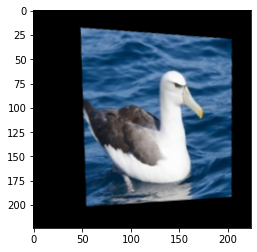

Label (number): 0, (name): ALBATROSS
TRUMPTER SWAN: 12.54%
BARN OWL: 10.86%
BALD EAGLE: 10.50%
EURASIAN MAGPIE: 10.49%
MALLARD DUCK: 10.41%
ALBATROSS: 9.60%
PELICAN: 9.33%
FLAMINGO: 9.09%
PEACOCK: 8.70%
OSTRICH: 8.48%


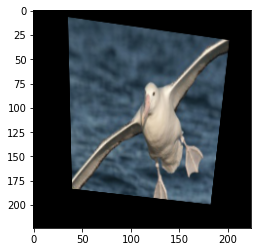

Label (number): 0, (name): ALBATROSS
MALLARD DUCK: 10.79%
BARN OWL: 10.52%
TRUMPTER SWAN: 10.34%
BALD EAGLE: 10.29%
EURASIAN MAGPIE: 10.28%
FLAMINGO: 10.02%
PELICAN: 9.82%
ALBATROSS: 9.58%
PEACOCK: 9.43%
OSTRICH: 8.92%


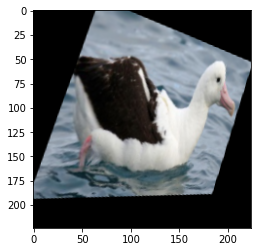

Label (number): 0, (name): ALBATROSS
TRUMPTER SWAN: 12.40%
BARN OWL: 10.69%
BALD EAGLE: 10.61%
EURASIAN MAGPIE: 10.56%
MALLARD DUCK: 10.01%
ALBATROSS: 9.77%
PELICAN: 9.58%
FLAMINGO: 9.57%
PEACOCK: 8.41%
OSTRICH: 8.40%


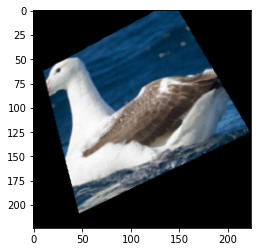

Label (number): 0, (name): ALBATROSS
TRUMPTER SWAN: 13.43%
EURASIAN MAGPIE: 10.22%
BALD EAGLE: 10.20%
FLAMINGO: 10.08%
BARN OWL: 9.95%
MALLARD DUCK: 9.92%
PELICAN: 9.72%
OSTRICH: 9.33%
ALBATROSS: 8.72%
PEACOCK: 8.44%


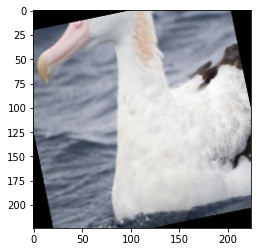

Label (number): 0, (name): ALBATROSS
TRUMPTER SWAN: 19.36%
BARN OWL: 10.64%
EURASIAN MAGPIE: 9.73%
MALLARD DUCK: 9.62%
ALBATROSS: 9.38%
PELICAN: 9.13%
BALD EAGLE: 8.86%
FLAMINGO: 8.67%
OSTRICH: 8.07%
PEACOCK: 6.54%


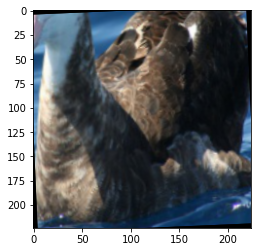

Label (number): 0, (name): ALBATROSS
MALLARD DUCK: 10.97%
FLAMINGO: 10.42%
BARN OWL: 10.30%
BALD EAGLE: 10.00%
EURASIAN MAGPIE: 9.98%
PEACOCK: 9.96%
PELICAN: 9.90%
TRUMPTER SWAN: 9.89%
OSTRICH: 9.34%
ALBATROSS: 9.24%


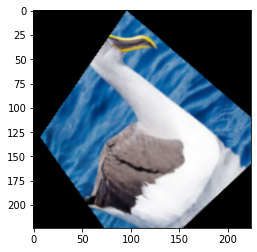

Label (number): 0, (name): ALBATROSS
TRUMPTER SWAN: 15.31%
BARN OWL: 10.82%
MALLARD DUCK: 10.29%
EURASIAN MAGPIE: 10.06%
BALD EAGLE: 9.76%
PELICAN: 9.55%
ALBATROSS: 9.34%
FLAMINGO: 9.06%
OSTRICH: 8.21%
PEACOCK: 7.60%


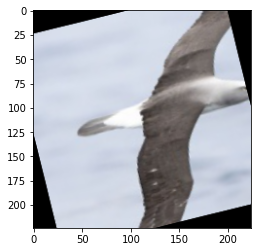

Label (number): 0, (name): ALBATROSS
TRUMPTER SWAN: 19.82%
BARN OWL: 9.88%
EURASIAN MAGPIE: 9.63%
MALLARD DUCK: 9.55%
PELICAN: 9.46%
FLAMINGO: 9.24%
OSTRICH: 8.71%
BALD EAGLE: 8.60%
ALBATROSS: 8.56%
PEACOCK: 6.54%


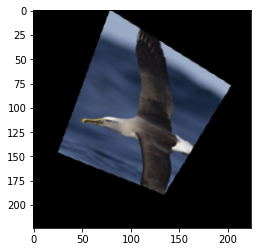

Label (number): 0, (name): ALBATROSS
BALD EAGLE: 10.87%
MALLARD DUCK: 10.68%
BARN OWL: 10.67%
EURASIAN MAGPIE: 10.32%
TRUMPTER SWAN: 10.09%
FLAMINGO: 9.77%
PELICAN: 9.67%
PEACOCK: 9.56%
ALBATROSS: 9.47%
OSTRICH: 8.88%


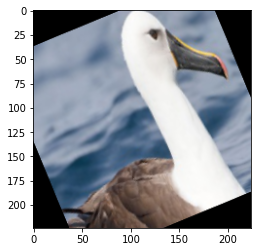

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label (number): 0, (name): ALBATROSS
TRUMPTER SWAN: 15.16%
BARN OWL: 10.78%
MALLARD DUCK: 10.41%
ALBATROSS: 9.97%
PELICAN: 9.75%
EURASIAN MAGPIE: 9.64%
FLAMINGO: 9.31%
BALD EAGLE: 9.00%
OSTRICH: 8.45%
PEACOCK: 7.54%


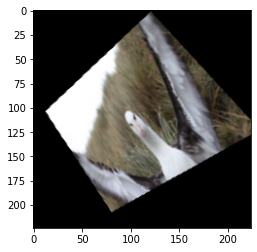

Label (number): 0, (name): ALBATROSS
TRUMPTER SWAN: 12.25%
BALD EAGLE: 10.72%
EURASIAN MAGPIE: 10.29%
FLAMINGO: 10.27%
BARN OWL: 10.20%
MALLARD DUCK: 9.83%
PELICAN: 9.65%
OSTRICH: 9.24%
ALBATROSS: 8.99%
PEACOCK: 8.57%


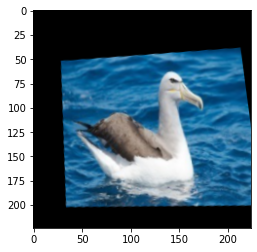

Label (number): 0, (name): ALBATROSS
TRUMPTER SWAN: 13.62%
BARN OWL: 10.46%
MALLARD DUCK: 10.41%
EURASIAN MAGPIE: 10.39%
BALD EAGLE: 10.30%
PELICAN: 9.35%
ALBATROSS: 9.24%
FLAMINGO: 9.10%
OSTRICH: 8.68%
PEACOCK: 8.46%


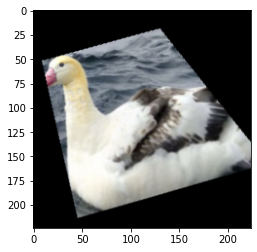

Label (number): 0, (name): ALBATROSS
TRUMPTER SWAN: 17.27%
EURASIAN MAGPIE: 10.02%
FLAMINGO: 9.84%
MALLARD DUCK: 9.69%
BARN OWL: 9.66%
OSTRICH: 9.43%
BALD EAGLE: 9.38%
PELICAN: 9.13%
ALBATROSS: 8.03%
PEACOCK: 7.54%


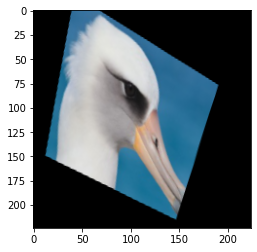

Label (number): 0, (name): ALBATROSS
TRUMPTER SWAN: 12.92%
BALD EAGLE: 10.39%
EURASIAN MAGPIE: 10.14%
BARN OWL: 10.13%
PELICAN: 10.08%
MALLARD DUCK: 9.88%
FLAMINGO: 9.80%
OSTRICH: 9.12%
ALBATROSS: 9.06%
PEACOCK: 8.48%


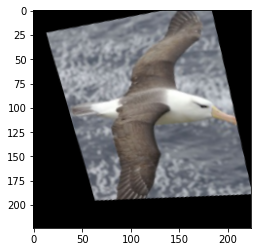

Label (number): 0, (name): ALBATROSS
TRUMPTER SWAN: 10.94%
EURASIAN MAGPIE: 10.45%
BARN OWL: 10.43%
MALLARD DUCK: 10.38%
PELICAN: 10.29%
FLAMINGO: 10.04%
BALD EAGLE: 10.03%
ALBATROSS: 9.75%
PEACOCK: 8.92%
OSTRICH: 8.77%


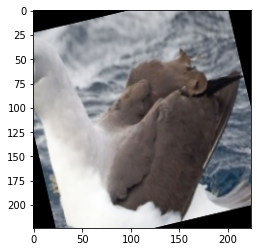

Label (number): 0, (name): ALBATROSS
TRUMPTER SWAN: 14.36%
MALLARD DUCK: 10.60%
PELICAN: 10.15%
FLAMINGO: 9.90%
BARN OWL: 9.77%
EURASIAN MAGPIE: 9.74%
OSTRICH: 9.56%
BALD EAGLE: 8.85%
ALBATROSS: 8.77%
PEACOCK: 8.30%


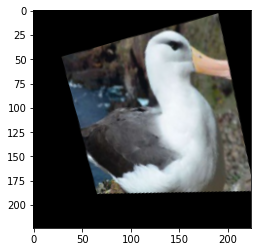

Label (number): 0, (name): ALBATROSS
TRUMPTER SWAN: 12.41%
BARN OWL: 10.96%
BALD EAGLE: 10.77%
EURASIAN MAGPIE: 10.56%
MALLARD DUCK: 10.13%
ALBATROSS: 9.74%
FLAMINGO: 9.40%
PELICAN: 9.25%
PEACOCK: 8.60%
OSTRICH: 8.17%


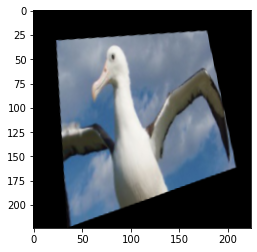

Label (number): 0, (name): ALBATROSS
TRUMPTER SWAN: 12.34%
BARN OWL: 10.58%
MALLARD DUCK: 10.38%
EURASIAN MAGPIE: 10.36%
BALD EAGLE: 10.18%
PELICAN: 9.86%
ALBATROSS: 9.52%
FLAMINGO: 9.34%
OSTRICH: 8.74%
PEACOCK: 8.70%


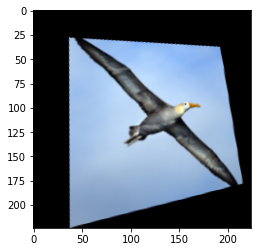

Label (number): 0, (name): ALBATROSS
TRUMPTER SWAN: 15.17%
EURASIAN MAGPIE: 10.29%
BARN OWL: 10.25%
BALD EAGLE: 10.03%
FLAMINGO: 9.64%
PELICAN: 9.53%
MALLARD DUCK: 9.50%
OSTRICH: 8.97%
ALBATROSS: 8.90%
PEACOCK: 7.73%


KeyboardInterrupt: 

In [21]:
#function for displaying a picture
import numpy as np
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def print_probs(prob_labels):
    for label, prob in prob_labels:
        print("{}: {:.2f}%".format(label, prob*100))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
display_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False)
for data in display_dataloader:
    images, labels = data[0].to(device), data[1].to(device)
    outputs = net(images)
    img = images[0].squeeze()
    label = labels[0].item()
    imshow(img)
    label_str = test_dataset.labels_int_to_str[label]
    print(f"Label (number): {label}, (name): {label_str}")
    prob_tensor = nn.Softmax(dim=1)(outputs.data).squeeze()
    prob_list = prob_tensor.tolist()
    prob_labels = [(test_dataset.labels_int_to_str[i], prob) for i, prob in enumerate(prob_list)]
    prob_labels.sort(key = lambda t : t[1], reverse=True)
    print_probs(prob_labels)
    